# Exercise 5

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import sys
sys.path.insert(0, '..')
from multiprocess import mp_pandas_obj

## Snippets

### SNIPPET 5.1 WEIGHTING FUNCTION

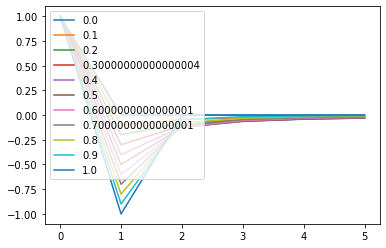

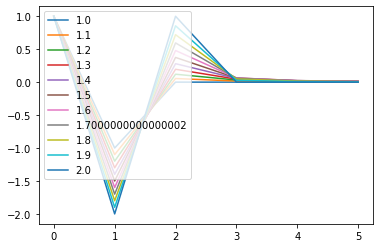

In [65]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w 

def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_=getWeights(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper left')
    return

if __name__=='__main__':
    plotWeights(dRange=[0,1],nPlots=11,size=6)
    plotWeights(dRange=[1,2],nPlots=11,size=6)

## SNIPPET 5.2 STANDARD FRACDIFF (EXPANDING WINDOW)

In [83]:
def fracDiff(series,d,thres=.01):
    """
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessairly bounded [0, 1].
    """
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshld
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method="ffill").dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]):continue #exclude NAs
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series(dtype=float)
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df
    

## SNIPPET 5.3 THE NEW FIXED-WIDTH WINDOW FRACDIFF METHOD

In [62]:
def getWeights_FFD(d,thres):
    # thres>0 drops insignificant weights
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        seriesF =series[[name]].fillna(method='ffill').dropna()
        df_=pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

## SNIPPET 5.4 FINDING THE MINIMUM D VALUE THAT PASSES THE ADF TEST

In [6]:
def plotMinFFD():
    path,instName='./','ES1_Index_Method12' 
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr']) 
    df0=pd.read_csv(path+instName+'.csv',index_col=0,parse_dates=True)
    for d in np.linspace(0,1,11):
        df1=np.log(df0[['Close']]).resample('1D').last() # downcast to daily obs 
        df2=fracDiff_FFD(df1,d,thres=.01) 
        corr=np.corrcoef(df1.loc[df2.index,'Close'],df2['Close'])[0,1] 
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None) 
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out.to_csv(path+instName+'_testMinFFD.csv') 
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    mpl.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted') 
    mpl.savefig(path+instName+'_testMinFFD.png')
    return


## 1) Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:

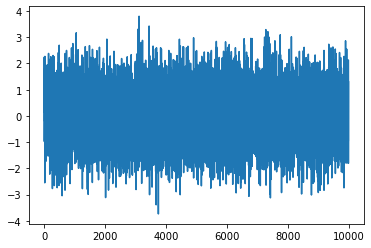

In [5]:
np.random.seed(0)

N = 10_000
s = pd.Series(np.random.randn(N))
s.plot();

### a) Compute the ADF statistic on this series. What is the p-value?

In [21]:
# Lambda functions? 
adf = lambda s: adfuller(s)
p_val = lambda s: adfuller(s)[1]

In [24]:
adf_statistic = adf(s)
print(f"p value is {adf_statistic[1]}")
adf_statistic

p value is 0.0


(-99.49026786274273,
 0.0,
 0,
 9999,
 {'1%': -3.4310041633725734,
  '5%': -2.861829101294412,
  '10%': -2.566923883481157},
 28010.559107207227)

### b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.

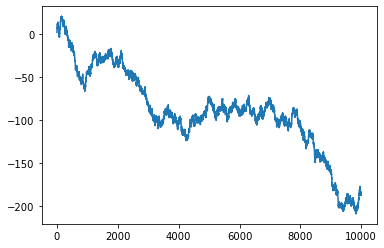

In [19]:
cmsm = pd.Series(s).cumsum()
cmsm.plot();

#### i) What is the order of integration of this cumulative series?

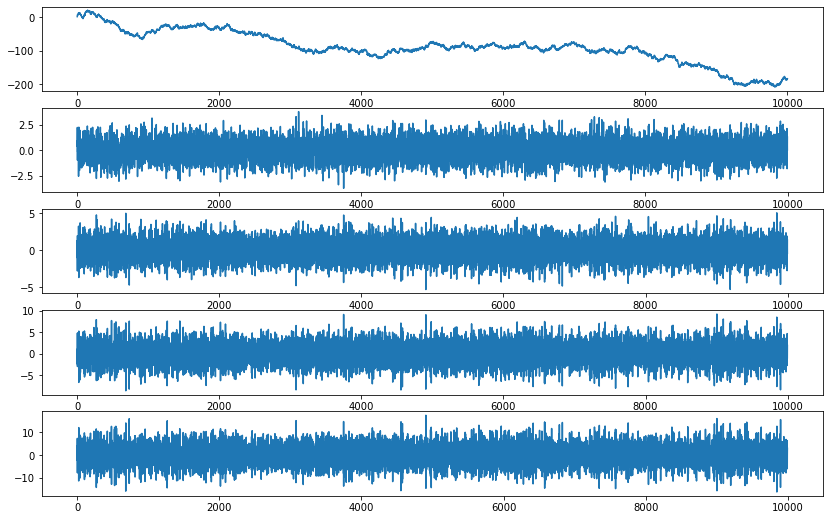

In [31]:
fig, (ax, ax1, ax2, ax3, ax4) = plt.subplots(5, figsize=(14, 9))

ax.plot(np.diff(cmsm, 0))
ax1.plot(np.diff(cmsm, 1))
ax2.plot(np.diff(cmsm, 2))
ax3.plot(np.diff(cmsm, 3))
ax4.plot(np.diff(cmsm, 4))

In [25]:
orders = [0, 1, 2, 3, 4]
for o in orders:
    diff_ = np.diff(cmsm,o)
    print('='*27)
    print(f'order: {o}, pVal: {p_val(diff_)}')

order: 0, pVal: 0.7653146162853299
order: 1, pVal: 0.0
order: 2, pVal: 0.0
order: 3, pVal: 0.0
order: 4, pVal: 0.0


#### ii) Compute the ADF statistic on this series. What is the p-value?

In [32]:
p_val(cmsm)

0.7653146162853299

### c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [33]:
diff_ = np.diff(cmsm,2)
p_val(diff_)

0.0

## 2) Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

<AxesSubplot:>

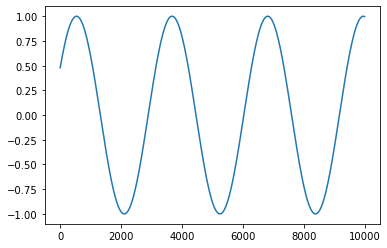

In [34]:
np.random.seed(0)

rand = np.random.random(N)

idx = np.linspace(0,10, N)
s = pd.Series(1*np.sin(2.*idx + .5))
s.plot()

### a) Compute the ADF statistic on this series. What is the p-value?

In [36]:
p_val(s)

0.0

### b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

<AxesSubplot:>

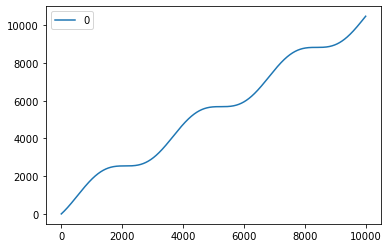

In [37]:
s_ = (s + 1).cumsum().to_frame()
s_.plot()

In [45]:
s_

,0
0,1.479426
1,2.960605
2,4.443538
3,5.928221
4,7.414652
...,...
9995,10471.274929
9996,10473.272219
9997,10475.269359
9998,10477.266346


#### i) Compute the ADF statistic on this series. What is the p-value?

In [49]:
adf(s_.dropna())

(26.109856678967738,
 1.0,
 24,
 9975,
 {'1%': -3.4310057377047953,
  '5%': -2.8618297969788036,
  '10%': -2.5669242537948884},
 -542797.0709216392)

In [50]:
p_val(s_)

1.0

#### ii) Apply an expanding window fracdiff, with $𝜏 = 1E − 2$. For what minimum $d$ value do you get a p-value below 5%?

In [84]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(s_,d)
        df0 = adfuller(df0,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except: 
        break


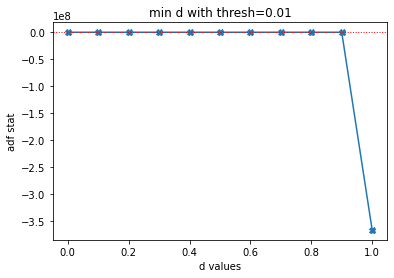

In [85]:
fig,ax=plt.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');


In [86]:
out

,adfStat,pVal,lags,nObs,95% conf
0.0,5.537228e+00,1.000000e+00,1.0,9997.0,-2.861829
0.1,1.107745e+01,1.000000e+00,1.0,3476.0,-2.862372
0.2,-3.810619e+01,0.000000e+00,1.0,4733.0,-2.862151
0.3,-1.615312e+01,4.547467e-29,1.0,6751.0,-2.861968
0.4,-5.019422e+01,0.000000e+00,1.0,8565.0,-2.861878
0.5,-4.575630e+01,0.000000e+00,1.0,9511.0,-2.861844
0.6,-6.308294e+01,0.000000e+00,1.0,9841.0,-2.861834
0.7,-5.851224e+01,0.000000e+00,1.0,9943.0,-2.861831
0.8,-2.560828e+01,0.000000e+00,1.0,9977.0,-2.861830
0.9,-1.177126e+01,1.088561e-21,1.0,9990.0,-2.861829


#### iii) Apply FFD, with $𝜏 = 1E − 5$. For what minimum $d$ value do you get a p-value below 5%?

In [90]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(s_,d,thres=1e-5)
        df0 = adfuller(df0,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except Exception as e:
        print(f'd: {d}, error: {e}')
        continue

d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


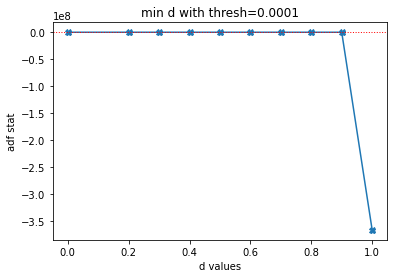

In [91]:
fig,ax=plt.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');

In [92]:
out

,adfStat,pVal,lags,nObs,95% conf
0.0,5.537228e+00,1.0,1.0,9997.0,-2.861829
0.2,-4.544005e+01,0.0,1.0,4.0,-4.474365
0.3,-8.920539e+03,0.0,1.0,11.0,-3.189369
0.4,-9.973427e+03,0.0,1.0,27.0,-2.976430
0.5,-8.606326e+03,0.0,1.0,68.0,-2.905087
0.6,-8.345086e+03,0.0,1.0,180.0,-2.877735
0.7,-1.022089e+04,0.0,1.0,513.0,-2.867190
0.8,-1.178766e+04,0.0,1.0,1559.0,-2.863396
0.9,-2.045429e+03,0.0,1.0,4652.0,-2.862161
1.0,-3.665842e+08,0.0,1.0,9996.0,-2.861829


## 3) Take the series from exercise 2.b